# Atividade 07 - Tarefa Final

Esta tarefa consiste em implementar o algoritmo backpropagation de um forma mais geral do que foi implementada na tarefa anterior (caso a implementação da tarefa anterior não seja generalizada).

Deve-se comparar o desempenho do algoritmo implementado com os classificadores sklearn.neural_network.MLPClassifier e uma implementação usando keras; usar bases binárias com e sem separação linear; plotar gráficos com meshgrid mostrando a separação de cada classificador.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.special import expit as sigmoide
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification, make_gaussian_quantiles
from sklearn.base import BaseEstimator, ClassifierMixin

## Classificadores

Utilizado o algoritmo implementado, o sklearn.neural_network.MLPClassifier e uma implementação usando keras

In [2]:
# 1. Implementado
class Implementado(BaseEstimator, ClassifierMixin):
    "Implementa uma rede neural com 3 camadas (entrada, oculta, saída)"
    
    def __init__(self):
        # Inicializa a rede neural
        self.taxa_aprendizado = 0.02
        self.numero_nos_entrada = 2
        self.numero_nos_ocultos = 2
        self.numero_nos_camada_saida = 1

        # Inicializa os pesos de forma randomica
        self.w_camada_oculta = np.random.random(size=(self.numero_nos_entrada, self.numero_nos_ocultos))
        self.b_camada_oculta = np.random.random(size=(1, self.numero_nos_ocultos))
        self.w_camada_saida = np.random.random(size=(self.numero_nos_ocultos, self.numero_nos_camada_saida))
        self.b_camada_saida = np.random.random(size=(1, self.numero_nos_camada_saida))

    def derivada_sigmoide(self, x):
        return x * (1 - x)

    def erro(self, y, y_calculado):
        return 0.5 * (y - y_calculado)**2

    def fit(self, X, y):
        # Treina a rede neural por 10 epocas e pare se o erro for menor que 1e-4
        epochs=10
        for e in range(epochs):
            for i in range(len(X)):
                # Etapa forward
                y_camada_oculta = sigmoide(np.dot(X[i], self.w_camada_oculta) + self.b_camada_oculta)
                y_calculado = sigmoide(np.dot(y_camada_oculta, self.w_camada_saida) + self.b_camada_saida)

                # Calcula o erro médio de todas as instancias
                e = self.erro(y[i], y_calculado).mean()
                if e < 1e-4:
                    break

                # Etapa backpropagation
                gradiente_camada_saida = (y_calculado - y[i]) * self.derivada_sigmoide(y_calculado)
                gradiente_camada_oculta = gradiente_camada_saida.dot(self.w_camada_saida.T) * self.derivada_sigmoide(y_camada_oculta)

                # Atualização dos parâmetros
                self.w_camada_saida -= self.taxa_aprendizado * y_camada_oculta.T.dot(gradiente_camada_saida)
                self.w_camada_oculta -= self.taxa_aprendizado * X[i].T.reshape(-1,1).dot(gradiente_camada_oculta)

                self.b_camada_saida -= self.taxa_aprendizado * np.sum(gradiente_camada_saida)
                self.b_camada_oculta -= self.taxa_aprendizado * np.sum(gradiente_camada_oculta)

    # Predict
    def predict(self, X):
        y_camada_oculta = sigmoide(np.dot(X, self.w_camada_oculta) + self.b_camada_oculta)
        y_calculado = sigmoide(np.dot(y_camada_oculta, self.w_camada_saida) + self.b_camada_saida)
        return np.round(y_calculado, 0)
    
    # Decision function para grafico
    def decision_function(self, X):
        y_camada_oculta = sigmoide(np.dot(X, self.w_camada_oculta) + self.b_camada_oculta)
        y_calculado = sigmoide(np.dot(y_camada_oculta, self.w_camada_saida) + self.b_camada_saida)
        return y_calculado

In [3]:
# 2. MLPCLassifier
from sklearn.neural_network import MLPClassifier

In [4]:
# 3. Usando Keras

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

# Função para criar o modelo para o wrapper KerasClassifier
def create_model():
    # Cria modelo
    model = Sequential()
    model.add(Dense(2, input_dim=2, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compila modelo
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [5]:
clfs = [
    ('Implementado', Implementado()),
    ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000)),
    ('Keras Classifier', KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0))
]

## Bases

Utilizadas bases binárias com e sem separação linear (make_classification e make_gaussian_quantiles):

In [6]:
datasets = [('Linear', make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2,
                    random_state=1, n_clusters_per_class=2)),
            ('Não linear', make_gaussian_quantiles(n_samples=100, n_features=2, n_classes=2, 
                    shuffle=True, random_state=1))
            ]

## Gráficos

Plotar gráficos com meshgrid mostrando a separação de cada classificador.

Dataset: Linear
Score Implementado: 0.53
Score MLPClassifier: 0.97
Score Keras Classifier: 0.90

Dataset: Não linear
Score Implementado: 0.47
Score MLPClassifier: 0.80
Score Keras Classifier: 0.62



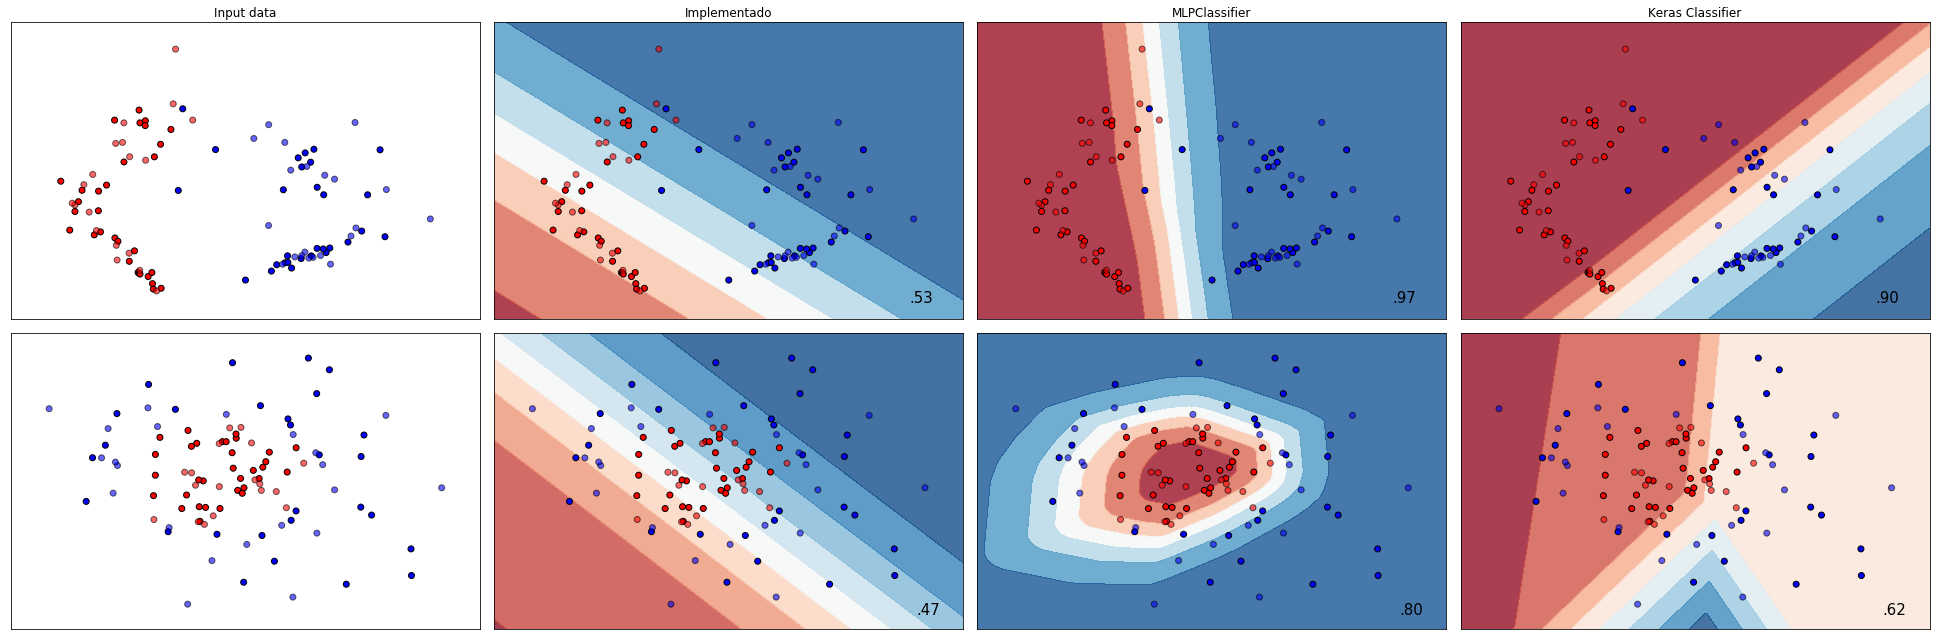

In [7]:
figure = plt.figure(figsize=(27, 9))

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    ds_name = ds[0]
    X, y = ds[1]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=1)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(clfs) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    print(f"Dataset: {ds_name}")
    # iterate over classifiers
    for name, clf in clfs:
        ax = plt.subplot(len(datasets), len(clfs) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print(f"Score {name}: {score:.2f}")

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

    print()

plt.tight_layout()
plt.show()